<a href="https://colab.research.google.com/github/zzzle96/PyTorch/blob/master/convlstm/convlstm1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/jhhuang96/ConvLSTM-PyTorch

Cloning into 'ConvLSTM-PyTorch'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 108 (delta 52), reused 59 (delta 18), pack-reused 0
Receiving objects: 100% (108/108), 9.50 MiB | 45.69 MiB/s, done.
Resolving deltas: 100% (52/52), done.


In [2]:
import sys
sys.path.append('/content/ConvLSTM-PyTorch')
print(sys.path)


['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/content/ConvLSTM-PyTorch']


In [3]:

import torch
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
import numpy as np
from utils import Encoder
from utils import Decoder
from utils import ED
from ConvLSTM import convlstm_encoder_params, convlstm_decoder_params
from mm import MovingMNIST

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
    img = img[0]
    img = torchvision.utils.make_grid(img)
    img = img.cpu()
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

input


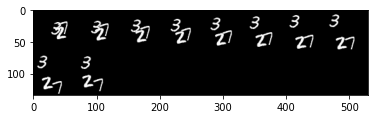

label


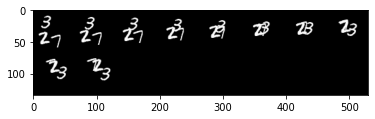

prediction


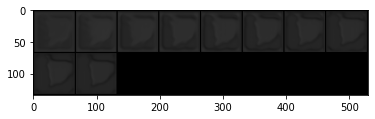

input


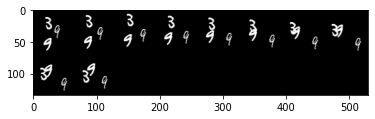

label


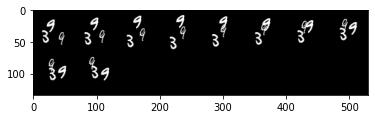

prediction


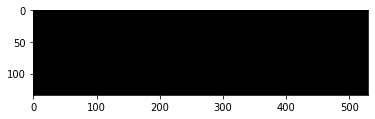

input


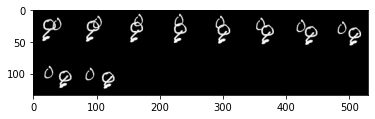

label


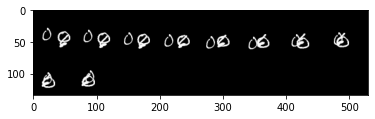

prediction


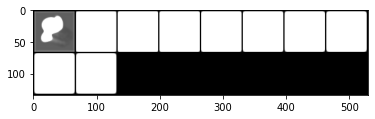

input


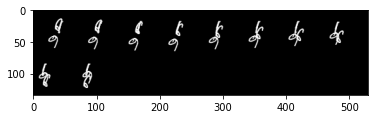

label


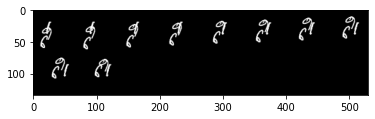

prediction


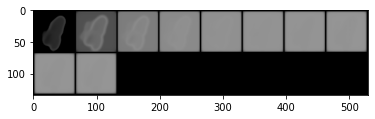

input


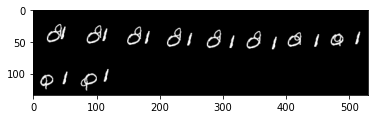

label


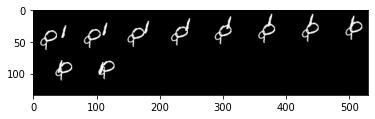

prediction


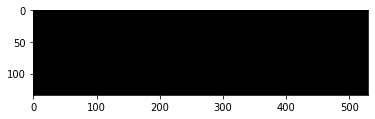

input


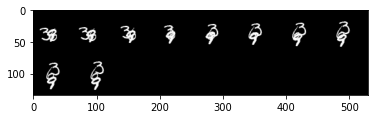

label


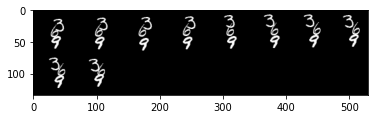

prediction


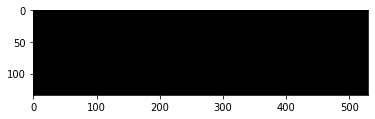

KeyboardInterrupt: ignored

In [6]:
frames_input = 10
frames_output = 10
batch_size = 10
lr = 0.1
epochs = 30
print_period = 1000

# Setting cuda
cuda_num = 0
device = torch.device(f'cuda:{cuda_num}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

trainFolder = MovingMNIST(is_train=True, root='/content/ConvLSTM-PyTorch/data', n_frames_input=frames_input, n_frames_output=frames_output, num_objects=[3])
validFolder = MovingMNIST(is_train=False, root='/content/ConvLSTM-PyTorch/data', n_frames_input=frames_input, n_frames_output=frames_output, num_objects=[3])
trainLoader = torch.utils.data.DataLoader(trainFolder, batch_size=batch_size, shuffle=False)
validLoader = torch.utils.data.DataLoader(validFolder, batch_size=batch_size, shuffle=False)

encoder_params = convlstm_encoder_params
decoder_params = convlstm_decoder_params
encoder = Encoder(encoder_params[0], encoder_params[1]).cuda()
decoder = Decoder(decoder_params[0], decoder_params[1]).cuda()

net = ED(encoder, decoder)
net.to(device)

criterion = nn.MSELoss().cuda()
optimizer = optim.Adam(net.parameters(), lr=lr)
pla_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=4, verbose=True)

for epoch in range(epochs):
    # Training
    net.train()
    for i, (idx, targetVar, inputVar, _, _) in enumerate(trainLoader):
    
        inputs = inputVar.to(device)  # B,S,C,H,W
        label = targetVar.to(device)  # B,S,C,H,W
        pred = net(inputs)  # B,S,C,H,W
        loss = criterion(pred, label)
        print('input')
        imshow(inputs)
        print('label')
        imshow(label)
        print('prediction')
        imshow(pred)
        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_value_(net.parameters(), clip_value=10.0)
        
        optimizer.step()

        if (i+1) % (print_period/batch_size) == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format
            (epoch+1, epochs, (i+1)*batch_size, len(trainLoader)*batch_size, loss.item()))

    # Validations
    net.eval()
    with torch.no_grad():
        for i, (idx, targetVar, inputVar, _, _) in enumerate(validLoader):
            
            inputs = inputVar.to(device)
            label = targetVar.to(device)
            pred = net(inputs)
            loss = criterion(pred, label)
            
            if (i+1) % (print_period/batch_size) == 0:
                if epoch+1 >= 15:
                    print('input')
                    imshow(inputs)
                    print('label')
                    imshow(label)
                    print('prediction')
                    imshow(pred)
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format
            (epoch+1, epochs, (i+1)*batch_size, len(validLoader)*batch_size, loss.item()))